In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

Let's try a different approach to understanding what functions a particular neural reservoir is good at computing.

We'll consider an LDN and a neural implementation of an LDN, but let's focus on conditions where a sine wave of different frequencies is our input.  And let's try computing an output that identifies the frequency of the input.

We start by looking at a system to distinguish a 1Hz wave from a 2Hz wave.  We begin with a standard LDN.

In [164]:
import scipy.linalg

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
        self.A = A / theta
        self.B = B / theta        
        
        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre
    


In [194]:
ldn = LDN(theta=0.5, q=12)
dt = 0.0005
T = 6

t = np.arange(int(T/dt))*dt
t.shape = (int(T/dt),1)
sin1 = np.sin(t*2*np.pi*1)
sin2 = np.sin(t*2*np.pi*2)

r1 = ldn.apply(sin1, dt=dt)
r2 = ldn.apply(sin2, dt=dt)
t1 = np.ones_like(sin1)
t2 = np.ones_like(sin2)*-1

r = np.vstack([r1, r2])

solver = nengo.solvers.LstsqL2()
dec, info = solver(r, np.vstack([t1, t2]))

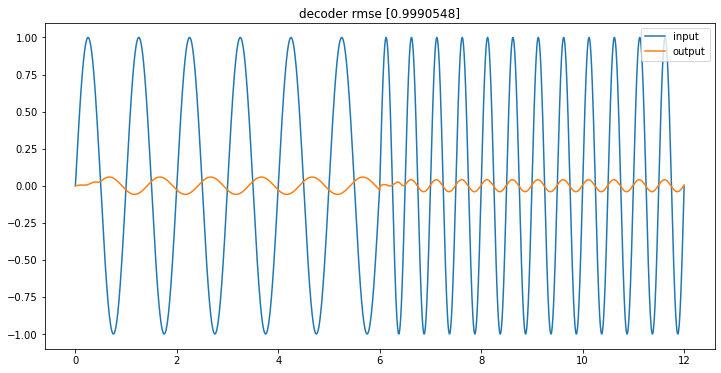

In [195]:
plt.figure(figsize=(12,6))

plt.plot(np.vstack([t,t+6]), np.vstack([sin1, sin2]), label='input')
plt.plot(np.vstack([t,t+6]), r @ dec, label='output')
plt.legend()
plt.title(f'decoder rmse {info["rmses"]}')
plt.show()

No, we can't classify the frequency just using an LDN.  So let's try it with some neurons.

In [196]:
import nengo
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=ldn.q,
                         intercepts=nengo.dists.CosineSimilarity(ldn.q+2),
                         neuron_type=nengo.LIFRate(), radius=2,
                         seed=0)
sim = nengo.Simulator(model)

_, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=r)

dec2, info2 = solver(a, np.vstack([t1, t2]))



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

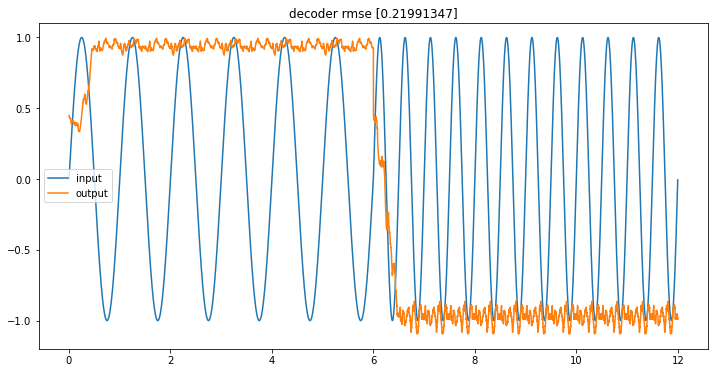

In [197]:
plt.figure(figsize=(12,6))

plt.plot(np.vstack([t,t+6]), np.vstack([sin1, sin2]), label='input')
plt.plot(np.vstack([t,t+6]), a @ dec2, label='output')
plt.legend()
plt.title(f'decoder rmse {info2["rmses"]}')
plt.show()

Excellent.  So now we know if we have neurons, we can do this task.  So can we now try characterizing these neurons like we do with traditional NEF non-temporal tuning curves?

Let's start by gathering data on how these two systems respond given different frequencies of inputs.  We'll sweep frequencies, in much the same way that in traditional tuning curves we sweep input values.

In [198]:
fs = np.linspace(0.5, 5, 40)
As = np.zeros((len(fs), ens.n_neurons, len(t)))
Rs = np.zeros((len(fs), ldn.q, len(t)))
for i, f in enumerate(fs):
    sin = np.sin(t*2*np.pi*f)
    r = ldn.apply(sin)
    Rs[i] = r.T
    _, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=r)
    As[i] = a.T

Now let's plot our mean response for each of these inputs.  Ideally, this mean would be over an infinitely long sine wave, but I don't have that kind of time available.  So, let's just do the mean over two full cycles of the input, but only start counting after theta seconds have gone by.



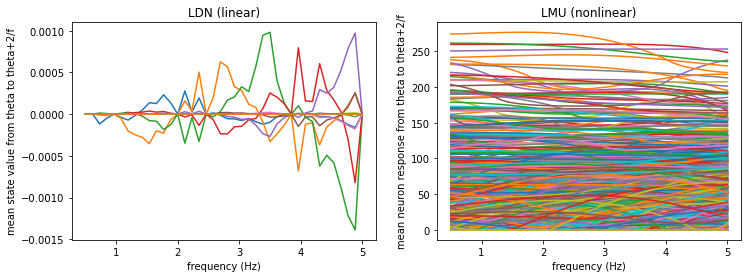

In [207]:
mean_Rs = np.zeros((len(fs), ldn.q))
mean_As = np.zeros((len(fs), ens.n_neurons))

for i, f in enumerate(fs):
    mean_Rs[i] = np.mean(Rs[i,:,int(ldn.theta/dt):int(ldn.theta/dt+2/f/dt)], axis=1)
    mean_As[i] = np.mean(As[i,:,int(ldn.theta/dt):int(ldn.theta/dt+2/f/dt)], axis=1)

    
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title('LDN (linear)')
plt.plot(fs, mean_Rs)
plt.xlabel('frequency (Hz)')
plt.ylabel('mean state value from theta to theta+2/f')
plt.subplot(1, 2, 2)
plt.title('LMU (nonlinear)')
plt.plot(fs, mean_As)
plt.xlabel('frequency (Hz)')
plt.ylabel('mean neuron response from theta to theta+2/f')
plt.show()


The graph on the left is a bit weird, as it seems to claim that the pure linear LDN can pick out some weird aspects of the frequency.  But, if I decrease dt towards zero, that graph approaches zero.  So I think that's just due to sampling error when I'm trying to add up responses over two cycles of the input.  I'm pretty sure if we we able to analytically do the math, those lines should all be zero.

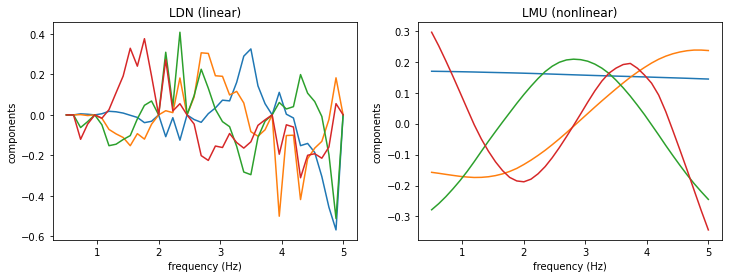

In [211]:
import sklearn.decomposition

n_components=4

pca_ldn  = sklearn.decomposition.PCA(n_components=n_components)
pca_ldn.fit(mean_Rs.T)

pca_lmu  = sklearn.decomposition.PCA(n_components=n_components)
pca_lmu.fit(mean_As.T)


plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title('LDN (linear)')
plt.plot(fs, pca_ldn.components_.T)
plt.xlabel('frequency (Hz)')
plt.ylabel('components')
plt.subplot(1, 2, 2)
plt.title('LMU (nonlinear)')
plt.plot(fs, pca_lmu.components_.T)
plt.xlabel('frequency (Hz)')
plt.ylabel('components')
plt.show()


Oh my.  Those LMU components look awfully familiar....  :)

So if I want an output that is a constant, given a sinusoidal input, that's my basis space I should be able to work with.

But what if I want an output that does change over time?  Let's try doing the PCA but without collapsing over time.

In [296]:
n_components = 12

d = np.transpose(As, axes=(1,0,2))
N = 2000

d = d[:,:,:N]  # only use the first N timesteps as it gets pretty repetative after that

pca2  = sklearn.decomposition.PCA(n_components=n_components)
pca2.fit(d.reshape((d.shape[0], -1)))

c = pca2.components_.reshape((n_components, len(fs), N))

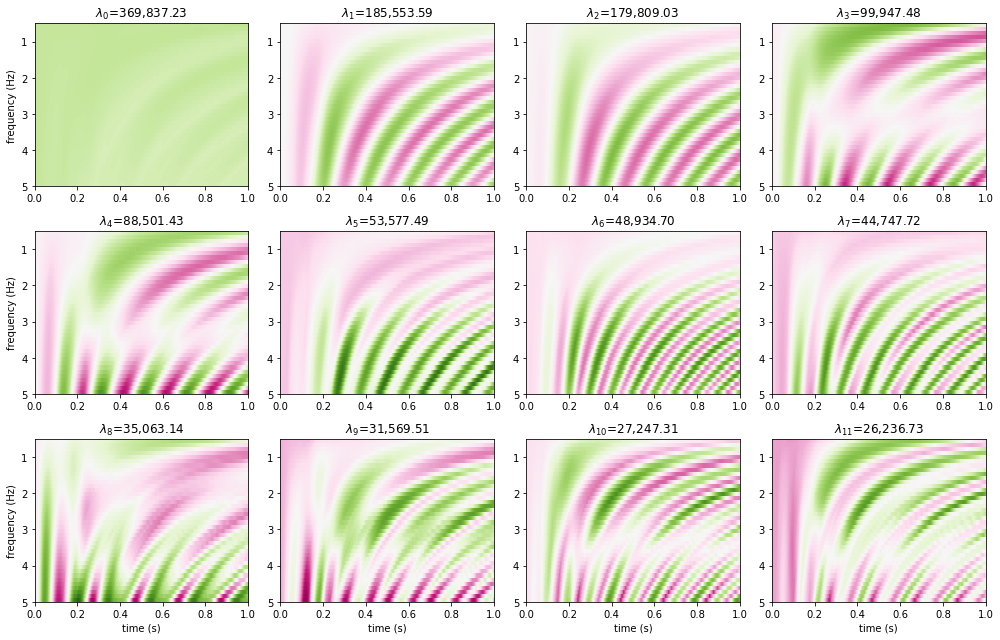

In [297]:
plt.figure(figsize=(14,9))

v = np.max(np.abs(c))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(c[i], aspect='auto', interpolation='none', extent=(0,2000*dt,fs[-1], fs[0]), vmin=-v, vmax=v, cmap='PiYG')
    plt.title(f'$\lambda_{{{i}}}$={pca2.singular_values_[i]:,.2f}')
    if i%4 == 0:
        plt.ylabel('frequency (Hz)')
    if i>=8:
        plt.xlabel('time (s)')
plt.tight_layout()
plt.show()

These seems to be the set of temporal basis functions for the class of functions that we should be able to compute, given sinusoidal inputs.

There might be some curve fitting we could do here to characterize these?  

And it also feels like it'd be nicer to write it in terms of phase, rather than time.

And of course we should go on to other inputs as well....